<a href="https://colab.research.google.com/github/Esubaalew/ResNET-with-small-dataset/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Implementing Deep Residual Learning (ResNet) for EuroSAT Image Classification

**Author:** Esubalew Chekol

**Date:** 31 May 2025  
**Objective:** To implement a ResNet architecture  using TensorFlow/Keras and train it on the EuroSAT dataset for land use and land cover classification. This notebook will also serve as a basis for a technical report, including discussions on the ResNet architecture and its predecessors.

---

## Introduction and Setup

This notebook demonstrates the implementation of a Deep Residual Network (ResNet), a seminal architecture in computer vision. We will build a ResNet model tailored for the EuroSAT dataset, which consists of satellite images for land use and land cover classification.

### Why ResNet?
ResNet, introduced by He *et al.* (2015), addressed the “degradation problem” in very deep neural networks, where adding more layers led to higher training error. It achieved this by introducing **shortcut connections** that allow the network to learn **residual functions**, making optimization easier for deeper structures.

### Why EuroSAT?
The EuroSAT dataset is chosen for this demonstration due to its manageable size (27,000 images, 64×64 pixels, 10 classes) and availability within TensorFlow Datasets. While ResNets are famously trained on massive datasets like ImageNet (~1.2 million images), using EuroSAT allows for:

- **Feasible Training**: Training on ImageNet from scratch requires significant computational resources (multiple high-end GPUs, extensive training time) often beyond the scope of typical local machines or free-tier cloud GPUs. EuroSAT allows us to demonstrate ResNet principles with more modest resources.
- **Focus on Implementation**: A smaller dataset lets us focus on the core implementation details of ResNet without being overwhelmed by large-scale data handling complexities.
- **Practical Application**: Satellite image classification is a relevant real-world problem with environmental and urban planning use cases.

---

In this first code cell, we will:

1. Import necessary libraries:
   - TensorFlow for building and training the neural network  
   - TensorFlow Datasets for loading EuroSAT  
   - Matplotlib for plotting  
   - NumPy for numerical operations  
2. Print the TensorFlow version to ensure compatibility and record the environment.


In [ ]:
#1: Imports and Setup

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


## GPU Availability Check

Before proceeding with data loading and model training, it’s good practice to check if TensorFlow can detect and utilize a GPU. Training deep learning models is significantly faster on GPUs compared to CPUs. This cell will:

1. List available physical GPUs.
2. Attempt to set memory growth on each GPU, which helps prevent TensorFlow from allocating all GPU memory at once—allowing other processes to use the GPU.


In [ ]:
# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs detected and configured.")
        for i, gpu_device in enumerate(gpus):
            print(f"  GPU {i}: {gpu_device.name}")
    except RuntimeError as e:

        print(f"Error during GPU setup: {e}")
        print("Proceeding, but GPU memory might not be optimally managed.")
else:
    print("No GPU detected by TensorFlow. Model will train on CPU, which will be slower.")

2 Physical GPUs, 2 Logical GPUs detected and configured.
  GPU 0: /physical_device:GPU:0
  GPU 1: /physical_device:GPU:1


I0000 00:00:1748696444.950423      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748696444.951177      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Loading the EuroSAT Dataset

We will now load the EuroSAT dataset using tensorflow_datasets (TFDS). TFDS provides a convenient way to access many public datasets.

**Dataset Details:**

- **Name:** EuroSAT (RGB version)
- **Content:** Satellite images from Sentinel-2.
- **Image Size:** 64×64 pixels.
- **Channels:** 3 (RGB).
- **Classes:** 10 distinct land use/land cover categories (e.g., "AnnualCrop", "Forest", "Residential").
- **Total Images:** 27,000.

**Splitting the Dataset:**  
The original EuroSAT dataset doesn’t have predefined splits. We will manually split the `train` portion provided by TFDS into training, validation, and test sets. A common split ratio is 70% for training, 15% for validation, and 15% for testing.

- `as_supervised=True`: Ensures the dataset yields `(image, label)` tuples.  
- `with_info=True`: Provides metadata about the dataset (e.g., number of classes, class names).  
- `shuffle_files=True`: Good practice for ensuring randomness when loading data that might be stored in multiple files.  


In [ ]:
# Dataset Loading and Initial Exploration

# Load EuroSAT dataset
(ds_train_raw, ds_val_raw, ds_test_raw), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], # 70% train, 15% val, 15% test
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


print("--- EuroSAT Dataset Information ---")
print(ds_info)


NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names
print(f"\nNumber of classes: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")


print(f"\nNumber of training samples: {tf.data.experimental.cardinality(ds_train_raw).numpy()}")
print(f"Number of validation samples: {tf.data.experimental.cardinality(ds_val_raw).numpy()}")
print(f"Number of test samples: {tf.data.experimental.cardinality(ds_test_raw).numpy()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.5OOK8R_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
--- EuroSAT Dataset Information ---
tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=()

## Dataset Preprocessing and Pipeline Creation

Raw image data needs to be preprocessed before it can be fed into a neural network. Our preprocessing steps will include:

- **Casting:** Converting image data type to `tf.float32`.
- **Normalization:** Scaling pixel values from the range `[0, 255]` to `[0, 1]`. This helps in stabilizing the training process.

    > **Note:** Some ResNet implementations use per-channel mean/std normalization based on ImageNet statistics, especially when using pre-trained weights. Since we are training from scratch on EuroSAT, simple `[0,1]` normalization is a reasonable starting point.

We will then set up efficient data pipelines using `tf.data`:

- `map()`: Applies the `preprocess_image` function to each element.
- `cache()`: Caches dataset elements in memory after the first epoch for faster subsequent epochs.
- `shuffle()`: Randomly shuffles the training data.
- `batch()`: Groups samples into batches.
- `prefetch()`: Allows the CPU to prepare data for the next batch while the GPU is processing the current batch, improving throughput. `AUTOTUNE` lets TensorFlow dynamically adjust the prefetch buffer size.

The native image size for EuroSAT is 64×64. We will use this directly as ResNets can be adapted to various input sizes, and upsampling to a larger size like 224×224 (common for ImageNet models) would add computational overhead and might not be necessary for this dataset.


In [ ]:
# Dataset Preprocessing

IMG_SIZE = 64  # Using the native image size of EuroSAT
BATCH_SIZE = 32 # A common batch size, can be tuned based on GPU memory
AUTOTUNE = tf.data.AUTOTUNE # For optimizing data pipeline performance

def preprocess_image(image, label):
    """
    Preprocesses an image:
    1. Casts image tensor to float32.
    2. Normalizes pixel values from [0, 255] to [0, 1].
    """
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label


ds_train = ds_train_raw.map(preprocess_image, num_parallel_calls=AUTOTUNE)
ds_val = ds_val_raw.map(preprocess_image, num_parallel_calls=AUTOTUNE)
ds_test = ds_test_raw.map(preprocess_image, num_parallel_calls=AUTOTUNE)


ds_train = ds_train.cache().shuffle(ds_info.splits['train[:70%]'].num_examples // 10).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)


print("\n--- Verifying Data Pipeline Output ---")
for images, labels in ds_train.take(1):
    print("Shape of a batch of images:", images.shape)
    print("Shape of a batch of labels:", labels.shape)
    break


--- Verifying Data Pipeline Output ---
Shape of a batch of images: (32, 64, 64, 3)
Shape of a batch of labels: (32,)


## Visualizing Sample Images

To get a better understanding of the EuroSAT dataset, let’s visualize a few sample images from our processed training set along with their corresponding labels. This helps confirm that the data loading and preprocessing steps are working as expected and gives us a qualitative feel for the classification task.



--- Sample Training Images ---


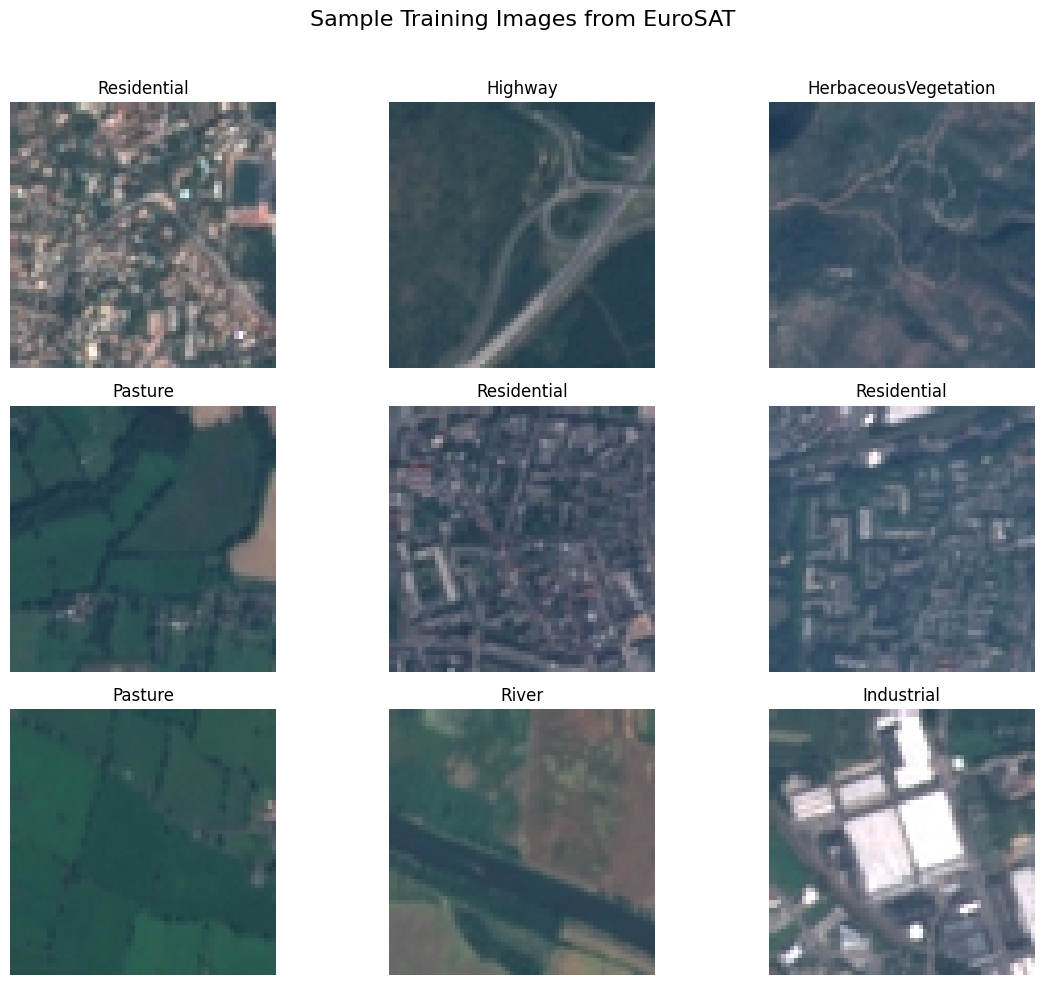

In [ ]:
# Visualize a few samples from the training set

print("\n--- Sample Training Images ---")
plt.figure(figsize=(12, 10))
for images, labels in ds_train.take(1):
    for i in range(min(9, BATCH_SIZE)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis("off")
plt.suptitle("Sample Training Images from EuroSAT", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## ResNet Architecture Implementation

This is the core of our project: implementing the ResNet architecture.

### Residual Blocks  
ResNet’s key innovation is the **residual block**, which uses shortcut (or skip) connections. Instead of learning a direct mapping \(H(x)\), the block learns a residual mapping \(F(x) = H(x) - x\). The output is then \(F(x) + x\), making it easier for the network to learn identity mappings if needed and mitigating the degradation problem in very deep networks.

We will implement a `residual_block` function that constructs one such block. It will include:

- **Two 3×3 convolutional layers** (the “basic block” structure used in ResNet-18/34).  
- **Batch Normalization** after each convolution (before ReLU for the first conv, after for the second conv before adding to shortcut).  
- **ReLU activation**.  
- **Shortcut connection**:  
  - If the input and output dimensions (number of filters or spatial size due to striding) are the same, use an identity connection.  
  - If dimensions change, use a **projection shortcut** (a 1×1 convolution) on the input `x` to match the output dimensions of `F(x)`.

---

### Building the ResNet Model (`build_resnet_for_eurosat`)  
Our model will be a simplified ResNet, suitable for 64×64 EuroSAT images. A full ResNet-50 would be too large and slow to train from scratch on this dataset.

**Model structure:**

1. **Stem**  
   - 3×3 convolutional layer (gentler on 64×64 inputs vs. original 7×7).  
   - Batch Normalization + ReLU.  
   - MaxPooling (2×2, stride 2) → reduces 64×64 → 32×32.

2. **Residual Stages**  
   - Configuration: `block_counts = [2, 2, 2]` (three stages, two blocks each).  
   - First block in stages 2 & 3 uses `stride=2` and doubles filters:  
     - Stage 1: `initial_filters` (e.g., 64), output 32×32.  
     - Stage 2: `initial_filters * 2` (e.g., 128), output 16×16.  
     - Stage 3: `initial_filters * 4` (e.g., 256), output 8×8.

3. **Classifier Head**  
   - Global Average Pooling (GAP) to reduce each feature map to a single value.  
   - Dense layer with softmax activation for 10-class classification.

**Kernel Initialization:**  
We use `he_normal` (He initialization) for conv and dense layers, optimized for ReLU activations.


In [ ]:
# ResNet Building Blocks and Model Definition

def residual_block(x, filters, strides=1, use_projection=False, block_name=""):
    """
    Creates a ResNet basic residual block.

    Args:
        x: Input tensor.
        filters: Number of filters for the convolutions in the main path.
        strides: Strides for the first convolution in the block (for downsampling).
                 The second convolution always has strides=1.
        use_projection: Boolean, whether to use a projection shortcut.
                        True if input and output dimensions don't match.
        block_name: String, base name for the layers in this block.

    Returns:
        Output tensor of the residual block.
    """

    shortcut = x

    # Main path
    # First convolution layer
    y = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same',
                      kernel_initializer='he_normal', name=f"{block_name}_conv1")(x)
    y = layers.BatchNormalization(name=f"{block_name}_bn1")(y)
    y = layers.ReLU(name=f"{block_name}_relu1")(y)

    # Second convolution layer
    y = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal', name=f"{block_name}_conv2")(y)
    y = layers.BatchNormalization(name=f"{block_name}_bn2")(y)

    # Add shortcut to main path
    # If dimensions change (due to striding or filter count change), a projection shortcut is needed.
    if use_projection:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same',
                                 kernel_initializer='he_normal', name=f"{block_name}_shortcut_conv")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{block_name}_shortcut_bn")(shortcut)

    output = layers.add([y, shortcut], name=f"{block_name}_add")
    output = layers.ReLU(name=f"{block_name}_relu_out")(output)
    return output

def build_resnet_for_eurosat(input_shape, num_classes, block_counts, initial_filters=64):
    """
    Builds a ResNet model tailored for smaller images like EuroSAT.

    Args:
        input_shape: Shape of the input images (height, width, channels).
        num_classes: Number of output classes.
        block_counts: A list indicating the number of residual blocks in each stage.
                      e.g., [2, 2, 2] creates 3 stages with 2 blocks each.
        initial_filters: Number of filters in the first convolutional layer of the stem.

    Returns:
        A Keras Model instance.
    """
    inputs = keras.Input(shape=input_shape, name="input_image")


    x = layers.Conv2D(initial_filters, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal', name="stem_conv")(inputs)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = layers.ReLU(name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same', name="stem_pool")(x)


    current_filters = initial_filters

    # Residual Stages
    for stage_idx, num_blocks_in_stage in enumerate(block_counts):
        stage_name = f"stage{stage_idx + 1}"
        for block_idx in range(num_blocks_in_stage):
            block_strides = 1
            use_projection_shortcut = False

            # First block of a new stage (except the very first stage if filters match)
            # is responsible for downsampling (if not the first stage) and increasing filters.
            if block_idx == 0:
                if stage_idx > 0: # For stage 2, 3, ...
                    block_strides = 2 # Downsample spatial dimensions
                    current_filters *= 2 # Double the number of filters
                    use_projection_shortcut = True # Dimension change requires projection
                # For the very first block of the first stage, if its target filter count (current_filters)
                # differs from the stem's output filter count (x.shape[-1]), projection is needed.
                # In our setup, initial_filters for stem and current_filters for stage1_block1 are the same.
                elif x.shape[-1] != current_filters: # Handles case if initial_filters != current_filters for stage 1
                     use_projection_shortcut = True


            # A projection is also needed if the input channels to a block don't match the block's target output channels,
            # even if strides are 1. This is covered by the stage_idx > 0 logic for filter increase.
            # The check `x.shape[-1] != current_filters` can also be used more generally if not handled by stage logic.
            if not use_projection_shortcut and x.shape[-1] != current_filters:
                 use_projection_shortcut = True


            x = residual_block(x, current_filters,
                               strides=block_strides,
                               use_projection=use_projection_shortcut,
                               block_name=f"{stage_name}_block{block_idx + 1}")


    x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)

    outputs = layers.Dense(num_classes, activation='softmax',
                           kernel_initializer='he_normal', name="classifier_dense")(x)

    model = keras.Model(inputs=inputs, outputs=outputs,
                        name=f"ResNet_EuroSAT_Blocks_{'_'.join(map(str, block_counts))}")
    return model


block_config = [2, 2, 2]


IMAGE_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

print("\n--- Building ResNet Model ---")
model = build_resnet_for_eurosat(
    input_shape=IMAGE_SHAPE,
    num_classes=NUM_CLASSES,
    block_counts=block_config,
    initial_filters=64
)


print("\n--- Model Summary ---")
model.summary()


tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file="resnet_eurosat_model.png")
print("\nModel architecture plot saved to resnet_eurosat_model.png")


--- Building ResNet Model ---

--- Model Summary ---


Model: "ResNet_EuroSAT_Blocks_2_2_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 64)     │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_relu (ReLU)          │ (None, 64, 64, 64)     │              0 │ stem_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_pool (MaxPooling2D)  │ (None, 32, 32, 64)     │              0 │ stem_relu[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block1_conv1       │ (None, 32, 32, 64)     │         36,928 │ stem_pool[0][0]        │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block1_bn1         │ (None, 32, 32, 64)     │            256 │ stage1_block1_conv1[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block1_relu1       │ (None, 32, 32, 64)     │              0 │ stage1_block1_bn1[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block1_conv2       │ (None, 32, 32, 64)     │         36,928 │ stage1_block1_relu1[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block1_bn2         │ (None, 32, 32, 64)     │            256 │ stage1_block1_conv2[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block1_add (Add)   │ (None, 32, 32, 64)     │              0 │ stage1_block1_bn2[0][… │
│                           │                        │                │ stem_pool[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block1_relu_out    │ (None, 32, 32, 64)     │              0 │ stage1_block1_add[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block2_conv1       │ (None, 32, 32, 64)     │         36,928 │ stage1_block1_relu_ou… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block2_bn1         │ (None, 32, 32, 64)     │            256 │ stage1_block2_conv1[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_block2_relu1  

 Total params: 2,784,394 (10.62 MB)

 Trainable params: 2,779,914 (10.60 MB)

 Non-trainable params: 4,480 (17.50 KB)


Model architecture plot saved to resnet_eurosat_model.png


## Compiling the Model

Before training, the model needs to be compiled. Compilation configures the learning process. We need to specify:

- **Optimizer:** The algorithm used to update the model weights. Adam (Adaptive Moment Estimation) is a popular and effective choice. We'll start with a learning rate of 1e-3 (0.001). Learning rate scheduling (e.g., reducing the learning rate over time) can often improve performance but is omitted here for simplicity.
- **Loss Function:** Measures how well the model is doing. For multi-class classification where labels are integers (0, 1, ..., N-1), `sparse_categorical_crossentropy` is appropriate. If labels were one-hot encoded, we would use `categorical_crossentropy`.
- **Metrics:** Used to monitor the training and testing steps. We'll use accuracy to see the percentage of correctly classified images.

```python
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)


In [ ]:
# Compile the Model

print("\n--- Compiling the Model ---")


optimizer = keras.optimizers.Adam(learning_rate=1e-3)


model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compiled successfully.")


--- Compiling the Model ---
Model compiled successfully.


## Training the Model

Now we train the model using the `fit()` method. This involves feeding the training data (`ds_train`) to the model and evaluating its performance on the validation data (`ds_val`) after each epoch.

**Key parameters for `fit()`:**

- `ds_train`: The training dataset.  
- `epochs`: The number of times to iterate over the entire training dataset. We'll start with a moderate number like 25. More epochs might be needed for better convergence, but this depends on the dataset and model complexity.  
- `validation_data`: Data on which to evaluate the loss and any model metrics at the end of each epoch. This helps monitor for overfitting.  
- `callbacks`: Functions that can be applied at different stages of training. We'll use:  
  - **EarlyStopping**: This callback monitors a specified metric (e.g., `val_loss`) and stops training if the metric doesn’t improve for a certain number of epochs (`patience`). It helps prevent overfitting and can save training time. `restore_best_weights=True` ensures the model weights are reverted to those from the epoch with the best validation performance.

The training history (loss and accuracy for training and validation sets over epochs) will be stored in the `history` object.


In [ ]:
# Train the Model

EPOCHS = 25

print(f"\n--- Starting Model Training for {EPOCHS} Epochs ---")


early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[early_stopping_cb]
)

print("Model training complete.")


--- Starting Model Training for 25 Epochs ---
Epoch 1/25


I0000 00:00:1748698212.103715      99 service.cc:148] XLA service 0x7e0bac020460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748698212.106452      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748698212.106521      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748698213.488251      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/591 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.1302 - loss: 2.6944   

I0000 00:00:1748698220.364437      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/591 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.5976 - loss: 1.1745 - val_accuracy: 0.7086 - val_loss: 0.8125
Epoch 2/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.7720 - loss: 0.6603 - val_accuracy: 0.7706 - val_loss: 0.6896
Epoch 3/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.8216 - loss: 0.5168 - val_accuracy: 0.7723 - val_loss: 0.7719
Epoch 4/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.8575 - loss: 0.4134 - val_accuracy: 0.8435 - val_loss: 0.4377
Epoch 5/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.8873 - loss: 0.3251 - val_accuracy: 0.8844 - val_loss: 0.3226
Epoch 6/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9099 - loss: 0.2611 - val_accuracy: 0.8827 - val_loss: 0.3569
Epoch 7/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9205 - loss: 0.2355 - val_accuracy: 0.9193 - val_loss: 0.2313
Epoch 8/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9287 - loss: 0.2093 - val_accurac

## Evaluating the Model and Visualizing Training History

After training, it’s crucial to evaluate the model’s performance on the unseen test set (`ds_test`). This gives a final, unbiased measure of how well the model generalizes.

We will also plot the training history (accuracy and loss for both training and validation sets over epochs). These plots are very informative:

- **Accuracy Plot:** Shows how training and validation accuracy change. Ideally, both should increase and converge. A large gap between training and validation accuracy indicates overfitting.
- **Loss Plot:** Shows how training and validation loss change. Ideally, both should decrease and converge. If validation loss starts to increase while training loss decreases, it’s a clear sign of overfitting.



--- Evaluating Model on the Test Set ---
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9263 - loss: 0.2106
Test Loss: 0.2099
Test Accuracy: 0.9252

--- Plotting Training History ---


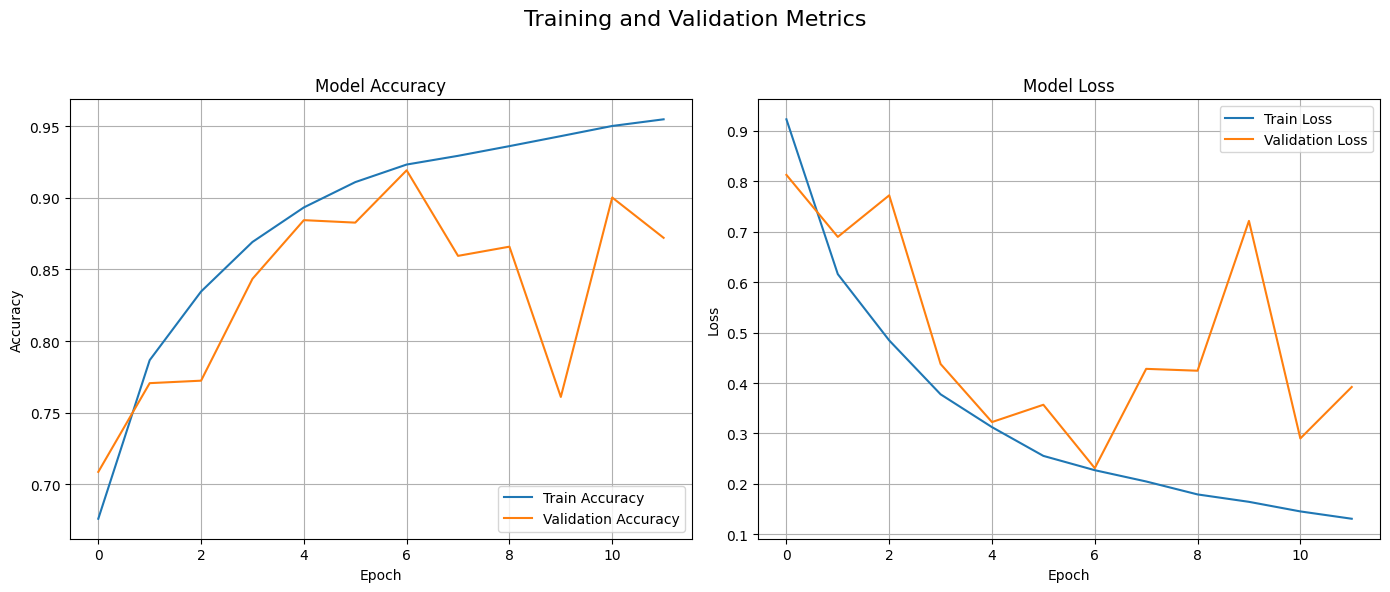

In [ ]:
#  Evaluate the Model and Plot History

print("\n--- Evaluating Model on the Test Set ---")

test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


def plot_training_history(training_history):
    """
    Plots the training and validation accuracy and loss.
    """
    plt.figure(figsize=(14, 6))


    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['accuracy'], label='Train Accuracy')
    plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Train Loss')
    plt.plot(training_history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.suptitle("Training and Validation Metrics", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("\n--- Plotting Training History ---")
plot_training_history(history)